In [1]:
import numpy as np
import matplotlib.pyplot as pltx
import seaborn as sns 
#escalas
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#algoritmos 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model

from keras.src.models.sequential import Sequential
from keras.src.layers import Dense
#métricas
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing #suavizado exponencial triple, que tiene en cuenta la estacionalidad
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima




In [2]:
#df = pd.read_excel("/Users/pablomunozdelorenzo/Desktop/ventasEcommerce.xlsx")
df = pd.read_excel("dataset/ventasEcommerce.xlsx") #asumiendo que está en el mismo directorio donde se ejecuta el proyecto

In [4]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Order_Date.1', 'day', 'week',
       'QUINCENA', 'month', 'MES', 'year', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State',
       'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub_Category',
       'Product_Name', 'Total'],
      dtype='object')

In [7]:
# Aplicar One-Hot Encoding para convertir los datos en numéricos. 
df_correlacion = df[["MES","year","Segment","Region","Category","Total"]]
df_one_hot = pd.get_dummies(df_correlacion)


<Axes: >

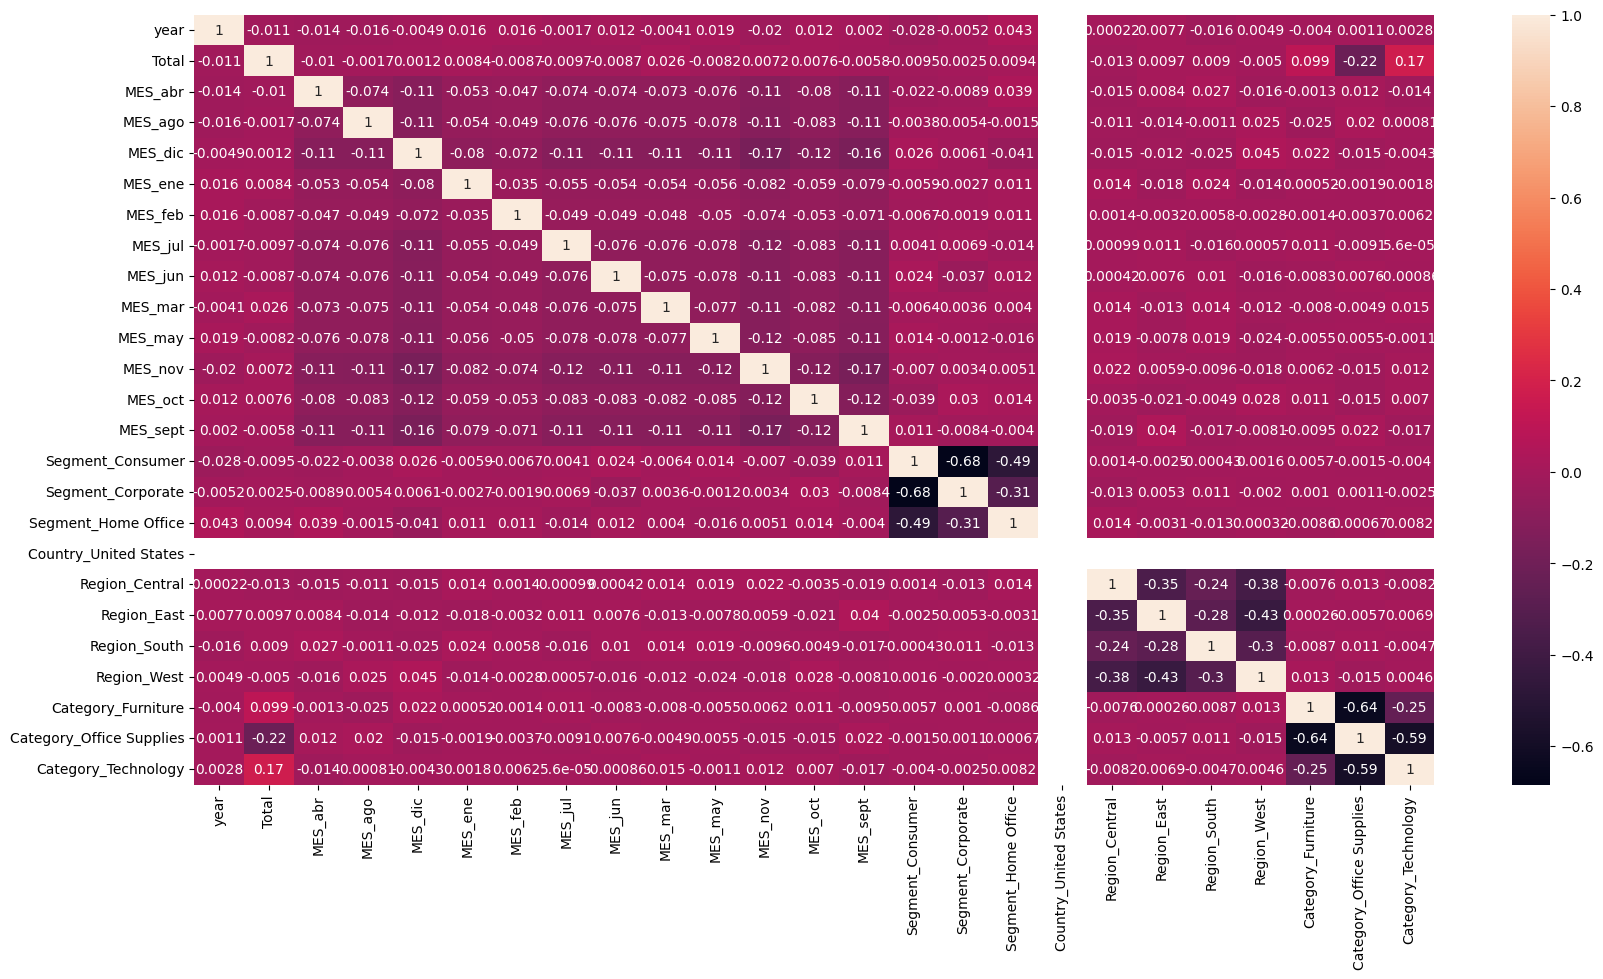

In [8]:
#comprobamos la correlación con el resto de campso
pltx.figure(figsize=(20,10))
sns.heatmap(df_one_hot.corr(),annot=True)

In [4]:
df["Order_Date"] = pd.to_datetime(df["Order_Date"])
df2 = df[["Order_Date","Total"]]

In [5]:
df_resultadoIng = df2.resample("ME",on="Order_Date").sum() #ingresos de entrenamiento
df_resultadoVent = df2.resample("ME",on="Order_Date").count() #ventas de entrenamiento

In [10]:
np.corrcoef(df_resultadoIng["Total"],df_resultadoVent["Total"])

array([[1.        , 0.92812353],
       [0.92812353, 1.        ]])

In [11]:
X_train = df_resultadoVent[0:36] # tres primeros años de ventas
X_test = df_resultadoVent[36:48] #último año de ventas
Y_train = df_resultadoIng[0:36] # tres primeros años de ingresos
Y_test = df_resultadoIng[36:48] #último año de ingresos
Y_test

,Total
Order_Date,
2018-01-31,43476.4740
2018-02-28,19920.9974
2018-03-31,58863.4128
2018-04-30,35541.9101
2018-05-31,43825.9822
2018-06-30,48190.7277
2018-07-31,44825.1040
2018-08-31,62837.8480
2018-09-30,86152.8880


In [12]:
scalerIng = StandardScaler()
scalerVent = StandardScaler()
X_trainEsc = scalerVent.fit_transform(X_train)
X_testEsc = scalerVent.transform(X_test)
Y_trainEsc = scalerIng.fit_transform(Y_train)
Y_testEsc = scalerIng.transform(Y_test)
print(len(X_trainEsc))
print(len(X_testEsc))
X_testEsc

36
12


array([[-0.44882513],
       [-0.90086996],
       [ 0.64071881],
       [ 0.21185577],
       [ 0.67549149],
       [ 0.61753702],
       [ 0.4784463 ],
       [ 0.37412827],
       [ 3.14435169],
       [ 1.30139971],
       [ 3.17912437],
       [ 3.21389705]])

In [13]:
print(scalerVent.inverse_transform(X_testEsc))
print(df_resultadoVent[36:48])

[[143.]
 [104.]
 [237.]
 [200.]
 [240.]
 [235.]
 [223.]
 [214.]
 [453.]
 [294.]
 [456.]
 [459.]]
            Total
Order_Date       
2018-01-31    143
2018-02-28    104
2018-03-31    237
2018-04-30    200
2018-05-31    240
2018-06-30    235
2018-07-31    223
2018-08-31    214
2018-09-30    453
2018-10-31    294
2018-11-30    456
2018-12-31    459


In [14]:
print(len(Y_trainEsc)/(len(Y_trainEsc)+len(Y_testEsc)))
print(len(X_trainEsc)/(len(X_trainEsc)+len(X_testEsc)))
print(len(Y_trainEsc))
print(len(Y_testEsc))

0.75
0.75
36
12


In [15]:
#implantamos los modelos
#comenzamos por regresión lineal
regr = linear_model.LinearRegression()
regr.fit(X_trainEsc,Y_trainEsc)
y_predRLEsc = regr.predict(X_testEsc)
resultado = np.concatenate((Y_testEsc,y_predRLEsc),axis=1)

In [16]:
#continuamos por random forest
#preparamos los datos
df3 = df[["Order_Date","Total","Category"]]
df3['Technology'] = (df3['Category'] == 'Technology').astype(int)
df3['Office Supplies'] = (df3['Category'] == 'Office Supplies').astype(int)
df3['Furniture'] = (df3['Category'] == 'Furniture').astype(int)
df_resultadoIng2 = df3.resample("ME",on="Order_Date").sum() #ingresos de entrenamiento
df_resultadoVent2 = df3.resample("ME",on="Order_Date").count() #ventas de entrenamiento
df_resultadoVent2 = df_resultadoIng2[["Technology","Office Supplies","Furniture"]]
df_resultadoVent2["Ventas Totales"] = df_resultadoVent2["Technology"] + df_resultadoVent2["Office Supplies"] + df_resultadoVent2["Furniture"]
df_resultadoIng2 = df_resultadoIng

C:\Users\Pablo\AppData\Local\Temp\ipykernel_22288\2327039246.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Technology'] = (df3['Category'] == 'Technology').astype(int)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_22288\2327039246.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Office Supplies'] = (df3['Category'] == 'Office Supplies').astype(int)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_22288\2327039246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [17]:
df_resultadoIng2

,Total
Order_Date,
2015-01-31,14205.7070
2015-02-28,4519.8920
2015-03-31,55205.7970
2015-04-30,27906.8550
2015-05-31,23644.3030
2015-06-30,34322.9356
2015-07-31,33781.5430
2015-08-31,27117.5365
2015-09-30,81623.5268


In [18]:
scalerVentRF = StandardScaler()
df_resultadoVentEsc2 = scalerVentRF.fit_transform(df_resultadoVent2)
X_trainEsc2 = df_resultadoVentEsc2[0:36] # tres primeros años de ventas
X_testEsc2 = df_resultadoVentEsc2[36:48] #último año de ventas

In [19]:
#modelo RF
rf_model = RandomForestRegressor(n_estimators=100,random_state=4)
rf_model.fit(X_trainEsc2, Y_trainEsc)
y_predRF = rf_model.predict(X_testEsc2)
resultado = np.column_stack((resultado,y_predRF))
resultado

C:\Users\Pablo\tutorial-env\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([[ 0.03136463, -0.42119666, -0.67936891],
       [-1.00482077, -0.84541481, -0.87732312],
       [ 0.70822299,  0.60127787,  0.12154249],
       [-0.31767009,  0.19881449,  0.57193252],
       [ 0.0467392 ,  0.63391003,  0.87587436],
       [ 0.23874065,  0.57952309,  0.75503124],
       [ 0.09068972,  0.44899443,  0.72979094],
       [ 0.88305502,  0.35109793,  0.01713189],
       [ 1.90866382,  2.9507938 ,  2.00420851],
       [ 1.52574896,  1.22128902,  1.43571458],
       [ 3.30687071,  2.98342597,  2.00420851],
       [ 1.77130773,  3.01605813,  2.00420851]])

In [20]:
scalerIng.inverse_transform(Y_testEsc)

array([[ 43476.474 ],
       [ 19920.9974],
       [ 58863.4128],
       [ 35541.9101],
       [ 43825.9822],
       [ 48190.7277],
       [ 44825.104 ],
       [ 62837.848 ],
       [ 86152.888 ],
       [ 77448.1312],
       [117938.155 ],
       [ 83030.3888]])

In [21]:
##comenzamos las predicciones de estacionalidad. 
df_resultadoIng

,Total
Order_Date,
2015-01-31,14205.7070
2015-02-28,4519.8920
2015-03-31,55205.7970
2015-04-30,27906.8550
2015-05-31,23644.3030
2015-06-30,34322.9356
2015-07-31,33781.5430
2015-08-31,27117.5365
2015-09-30,81623.5268


In [22]:
#suavizado exponencial
modeloSE = ExponentialSmoothing(df_resultadoIng[0:36],seasonal_periods=12, trend='add', seasonal='add')
ajusteSE = modeloSE.fit()
y_predSE = ajusteSE.forecast(steps = len(df_resultadoIng[36:48]))
y_predSE

C:\Users\Pablo\tutorial-env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2018-01-31     30407.728742
2018-02-28     30537.923623
2018-03-31     56151.893477
2018-04-30     51623.912188
2018-05-31     59040.531183
2018-06-30     47934.880339
2018-07-31     52952.619865
2018-08-31     54386.569946
2018-09-30     95633.395068
2018-10-31     55487.017431
2018-11-30    101054.618238
2018-12-31     96168.562128
Freq: ME, dtype: float64

In [23]:
print(r2_score(df_resultadoIng[36:48],y_predSE))

0.7562577255539945


In [24]:
#Sarimax
modeloSarimax = auto_arima(df_resultadoIng[0:36],start_p=0,d=1,start_q=0,
                         max_p=4,max_d=2,max_q=4,start_P=0,
                         D=1,start_Q=0,max_P=2,max_D=1, 
                        max_Q= 2,m=12, seasonal= True, error_action="warn",
                        trace= True, suppress_warnings=True, stepwise= True,
                        random_state= 20, n_fits=50)
print(modeloSarimax)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=514.796, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=508.768, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=507.790, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=515.262, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=508.871, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=509.375, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=509.370, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=510.395, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=507.867, Time=0.07 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=513.716, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
T

In [25]:
arima_model = SARIMAX(df_resultadoIng[0:36],exog=df_resultadoVent[0:36],order=(0,1,1),seasonal_order=(0,1,1,12)).fit(method="bfgs")
y_predSarimax = arima_model.predict(start = "2018-01-01", end = "2018-12-30",exog = df_resultadoVent[36:48] ,typ="levels")
y_predSarimax

C:\Users\Pablo\tutorial-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


         Current function value: 6.772758
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51


C:\Users\Pablo\tutorial-env\Lib\site-packages\scipy\optimize\_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
C:\Users\Pablo\tutorial-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Pablo\tutorial-env\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2018-01-31     32720.416811
2018-02-28     24066.923168
2018-03-31     65745.437217
2018-04-30     44937.389410
2018-05-31     57004.678493
2018-06-30     50369.864354
2018-07-31     47127.701005
2018-08-31     43251.520045
2018-09-30    101577.928529
2018-10-31     74194.716569
2018-11-30    104467.510158
2018-12-31    117726.508206
Freq: ME, Name: predicted_mean, dtype: float64

In [26]:
print(r2_score(df_resultadoIng[36:48],y_predSarimax))

0.6910413655153816


In [27]:
#escalamos ambos resultados y los añadimos al array
y_predSarimaxEsc = scalerIng.transform(pd.DataFrame(y_predSarimax).values)
y_predSEEsc = scalerIng.transform(pd.DataFrame(y_predSE).values)
resultado = np.column_stack((resultado,y_predSarimaxEsc,y_predSEEsc))
resultado

C:\Users\Pablo\tutorial-env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Pablo\tutorial-env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[ 0.03136463, -0.42119666, -0.67936891, -0.44178518, -0.54351837],
       [-1.00482077, -0.84541481, -0.87732312, -0.82244502, -0.53779121],
       [ 0.70822299,  0.60127787,  0.12154249,  1.0109574 ,  0.58894556],
       [-0.31767009,  0.19881449,  0.57193252,  0.09562906,  0.38976351],
       [ 0.0467392 ,  0.63391003,  0.87587436,  0.62645885,  0.71601428],
       [ 0.23874065,  0.57952309,  0.75503124,  0.33459902,  0.22748614],
       [ 0.09068972,  0.44899443,  0.72979094,  0.191979  ,  0.44821224],
       [ 0.88305502,  0.35109793,  0.01713189,  0.0214691 ,  0.51129048],
       [ 1.90866382,  2.9507938 ,  2.00420851,  2.58719825,  2.32570327],
       [ 1.52574896,  1.22128902,  1.43571458,  1.38263402,  0.55969823],
       [ 3.30687071,  2.98342597,  2.00420851,  2.71430849,  2.56417827],
       [ 1.77130773,  3.01605813,  2.00420851,  3.29756054,  2.34924481]])

In [28]:
#redes neuronales
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))  # Capa oculta con 64 neuronas y función de activación ReLU
model.add(Dense(1))  # Capa de salida con una neurona (predicción de ingresos)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # Compilar el modelo con el optimizador Adam y la pérdida MSE
model.summary()

C:\Users\Pablo\tutorial-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.fit(X_trainEsc, Y_trainEsc, epochs=100, batch_size=32, validation_data=(X_testEsc, Y_testEsc))
predicciones_2018 = model.predict(X_testEsc)
resultado = np.column_stack((resultado, predicciones_2018))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.0000e+00 - loss: 0.8111 - val_accuracy: 0.0000e+00 - val_loss: 1.1182
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.7846 - val_accuracy: 0.0000e+00 - val_loss: 1.0456
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.7374 - val_accuracy: 0.0000e+00 - val_loss: 0.9779
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.6888 - val_accuracy: 0.0000e+00 - val_loss: 0.9140
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.6619 - val_accuracy: 0.0000e+00 - val_loss: 0.8548
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.6116 - val_accuracy: 0.0000e+00 - val_loss: 0.8015
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.5869 - val_accuracy: 0.0000e+00 - val_loss: 0.7545
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy:

In [30]:
df_predicciones = pd.DataFrame(resultado,index=df_resultadoVent[36:48].index.values,columns = ['Valor Real', 'Regresión Lineal', 'Random Forest', 'Sarimax', 'Suavización Exponencial',"Red Neuronal"])
df_predicciones

,Valor Real,Regresión Lineal,Random Forest,Sarimax,Suavización Exponencial,Red Neuronal
2018-01-31,0.031365,-0.421197,-0.679369,-0.441785,-0.543518,-0.525487
2018-02-28,-1.004821,-0.845415,-0.877323,-0.822445,-0.537791,-0.860153
2018-03-31,0.708223,0.601278,0.121542,1.010957,0.588946,0.739039
2018-04-30,-0.317670,0.198814,0.571933,0.095629,0.389764,0.352997
2018-05-31,0.046739,0.633910,0.875874,0.626459,0.716014,0.765243
2018-06-30,0.238741,0.579523,0.755031,0.334599,0.227486,0.721569
2018-07-31,0.090690,0.448994,0.729791,0.191979,0.448212,0.610730
2018-08-31,0.883055,0.351098,0.017132,0.021469,0.511290,0.524892
2018-09-30,1.908664,2.950794,2.004209,2.587198,2.325703,2.580127
2018-10-31,1.525749,1.221289,1.435715,1.382634,0.559698,1.228405


In [31]:
r2RL = r2_score(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
r2RF = r2_score(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
r2Sarimax = r2_score(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
r2SE = r2_score(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
r2RN = r2_score(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])
mseRL = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
mseRF = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
mseSarimax = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
mseSE = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
mseRN = mean_squared_error(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])
maeRL = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
maeRF = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
maeSarimax = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
maeSE = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
maeRN = mean_absolute_error(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])
mapeRL = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Regresión Lineal"])
mapeRF = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Random Forest"])
mapeSarimax = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Sarimax"])
mapeSE = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Suavización Exponencial"])
mapeRN = mean_absolute_percentage_error(df_predicciones['Valor Real'], df_predicciones["Red Neuronal"])

In [32]:
#calcular todos los errores (mae, mse, mape) y hacer una tablita
index = ["Coeficiente de determinación", "Error cuadrático medio","Error absoluto medio","Porcentaje de error absoluto medio"]
arrayMetrica = np.array([[r2RL, r2RF, r2Sarimax, r2SE, r2RN],
                  [mseRL, mseRF, mseSarimax, mseSE,mseRN],
                        [maeRL,maeRF,maeSarimax,maeSE,maeRN],
                        [mapeRL,mapeRF,mapeSarimax,mapeSE,mapeRN]]) #hecho con los valores nuevos de RF
df_metricas = pd.DataFrame(arrayMetrica,index=index,columns=['Regresión Lineal', 'Random Forest', 'Sarimax', 'Suavización Exponencial', "Redes Neuronales"])
df_metricas


,Regresión Lineal,Random Forest,Sarimax,Suavización Exponencial,Redes Neuronales
Coeficiente de determinación,0.727600,0.641987,0.691041,0.756258,0.760783
Error cuadrático medio,0.351119,0.461474,0.398243,0.314180,0.308347
Error absoluto medio,0.497366,0.573842,0.495873,0.498513,0.501034
Porcentaje de error absoluto medio,3.037836,4.581699,2.781913,3.443455,3.735990


In [33]:
#una vez tenemos predichos los ingresos de 2018, pasamos a predecir los de 2019. Para ello, entrenaremos el modelo con
#los datos entre 2016 a 2018, y en base a ellos predeciremos los de 2019 usando suavizado exponencial 
modeloSE2019 = ExponentialSmoothing(df_resultadoIng[12:48],seasonal_periods=12, trend='add', seasonal='add')
ajusteSE2019 = modeloSE2019.fit()
y_predSE2019 = ajusteSE2019.forecast(steps = len(df_resultadoIng[36:48]))
y_predSE2019

C:\Users\Pablo\tutorial-env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2019-01-31     49682.408073
2019-02-28     40135.135966
2019-03-31     73568.403794
2019-04-30     55112.106270
2019-05-31     67276.278734
2019-06-30     60818.224836
2019-07-31     61453.022672
2019-08-31     61866.994373
2019-09-30     94522.396066
2019-10-31     73967.755768
2019-11-30    106402.971754
2019-12-31    114474.811994
Freq: ME, dtype: float64

In [34]:
dfy_predSE2019 = pd.DataFrame(y_predSE2019,columns = ["Total"])
df_resultadoIngFinal = pd.concat([df_resultadoIng, dfy_predSE2019])
df_resultadoIngFinal["month"] = df_resultadoIngFinal.index.month
df_resultadoIngFinal["year"] = df_resultadoIngFinal.index.year
df_resultadoIngFinal = df_resultadoIngFinal.pivot(index="month",columns="year",values="Total")
df_resultadoIngFinal

year,2015,2016,2017,2018,2019
month,,,,,
1,14205.7070,18066.9576,18542.4910,43476.4740,49682.408073
2,4519.8920,11951.4110,22978.8150,19920.9974,40135.135966
3,55205.7970,32339.3184,51165.0590,58863.4128,73568.403794
4,27906.8550,34154.4685,38679.7670,35541.9101,55112.106270
5,23644.3030,29959.5305,56656.9080,43825.9822,67276.278734
6,34322.9356,23599.3740,39724.4860,48190.7277,60818.224836
7,33781.5430,28608.2590,38320.7830,44825.1040,61453.022672
8,27117.5365,36818.3422,30542.2003,62837.8480,61866.994373
9,81623.5268,63133.6060,69193.3909,86152.8880,94522.396066


In [35]:
#una vez tenemos los ingresos de 2019, calculamos las ventas equivalentes. Usamos RN
#primero comprobamos que modelo usar
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))  # Capa oculta con 64 neuronas y función de activación ReLU
model.add(Dense(1))  # Capa de salida con una neurona (predicción de ingresos)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 
model.fit(Y_trainEsc, X_trainEsc, epochs=100, batch_size=32,validation_data=(Y_testEsc,X_testEsc))
prediccionesVentas_2018 = model.predict(Y_testEsc)
print("r2:",r2_score(X_testEsc,prediccionesVentas_2018))
print("mse",mean_squared_error(X_testEsc,prediccionesVentas_2018))

Epoch 1/100


C:\Users\Pablo\tutorial-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.0000e+00 - loss: 0.9958 - val_accuracy: 0.0000e+00 - val_loss: 2.1762
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.9235 - val_accuracy: 0.0000e+00 - val_loss: 2.1112
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.8682 - val_accuracy: 0.0000e+00 - val_loss: 2.0518
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.8746 - val_accuracy: 0.0000e+00 - val_loss: 1.9963
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.8291 - val_accuracy: 0.0000e+00 - val_loss: 1.9453
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 0.7671 - val_accuracy: 0.0000e+00 - val_loss: 1.8930
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 0.7692 - val_accuracy: 0.0000e+00 - val_loss: 1.8416
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 

In [36]:
regr = linear_model.LinearRegression()
regr.fit(Y_trainEsc,X_trainEsc)
X_predRLEsc = regr.predict(Y_testEsc)
print(r2_score(X_testEsc,X_predRLEsc))
print(mean_squared_error(X_testEsc,X_predRLEsc))

0.7387825657658229
0.47230717489245055


In [37]:
#preparamos los datos. Entrenaremos al modelo con datos de 2016 a 2018 para predecir 2019
X_trainP = np.concatenate((X_trainEsc[12:36],X_testEsc))#ventas 2016-2018
Y_trainP = np.concatenate((Y_trainEsc[12:36],Y_testEsc))#ingresos 2016-2018
Y_testP = scalerIng.transform(pd.DataFrame(y_predSE2019,columns = ["Total"]))#ingresos 2019
X_trainP

array([[-1.44564193],
       [-1.36450568],
       [-0.62268853],
       [-0.26337085],
       [-0.44882513],
       [-0.61109764],
       [-0.52996138],
       [-0.27496174],
       [ 1.19708167],
       [-0.20541638],
       [ 1.61435382],
       [ 1.49844489],
       [-1.07473336],
       [-1.14427871],
       [-0.24018906],
       [-0.15905281],
       [ 0.45526452],
       [ 0.16549219],
       [ 0.16549219],
       [-0.07791656],
       [ 1.93889882],
       [ 0.11912862],
       [ 2.135944  ],
       [ 1.811399  ],
       [-0.44882513],
       [-0.90086996],
       [ 0.64071881],
       [ 0.21185577],
       [ 0.67549149],
       [ 0.61753702],
       [ 0.4784463 ],
       [ 0.37412827],
       [ 3.14435169],
       [ 1.30139971],
       [ 3.17912437],
       [ 3.21389705]])

In [38]:
#si no mejora, utilizar RL
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))  # Capa oculta con 64 neuronas y función de activación ReLU
model.add(Dense(1))  # Capa de salida con una neurona (predicción de ingresos)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 
model.fit(Y_trainP, X_trainP, epochs=100, batch_size=32)
prediccionesVentas_2019Esc = model.predict(Y_testP)
prediccionesVentas_2019 = np.round(scalerVent.inverse_transform(prediccionesVentas_2019Esc))
prediccionesVentas_2019

Epoch 1/100


C:\Users\Pablo\tutorial-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 0s/step - accuracy: 0.0000e+00 - loss: 2.3358   
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 2.1936  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 2.0898
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 1.9854  
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 2.0679
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 1.8710  
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 1.9409
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 1.8498  
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1.6539 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 1.7609  
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.0000e+00 - loss: 1.6134
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

array([[236.],
       [181.],
       [315.],
       [259.],
       [297.],
       [277.],
       [279.],
       [281.],
       [375.],
       [316.],
       [408.],
       [431.]], dtype=float32)

In [39]:
X_test

,Total
Order_Date,
2018-01-31,143
2018-02-28,104
2018-03-31,237
2018-04-30,200
2018-05-31,240
2018-06-30,235
2018-07-31,223
2018-08-31,214
2018-09-30,453


In [40]:
regr = linear_model.LinearRegression()
regr.fit(Y_trainP,X_trainP)
X_predRLEsc2019 = regr.predict(Y_testP)
X_predRL2019 = np.round(scalerVent.inverse_transform(X_predRLEsc2019))
X_predRL2019 = pd.DataFrame(X_predRL2019,index = y_predSE2019.index, columns=["Total"])
X_predRL2019

,Total
2019-01-31,219.0
2019-02-28,180.0
2019-03-31,315.0
2019-04-30,241.0
2019-05-31,289.0
2019-06-30,264.0
2019-07-31,266.0
2019-08-31,268.0
2019-09-30,399.0
2019-10-31,316.0


In [41]:
PorcentajeTecnología = df_resultadoVent2["Technology"] / df_resultadoVent2["Ventas Totales"]
PorcentajeOfficeSupplies = df_resultadoVent2["Office Supplies"] / df_resultadoVent2["Ventas Totales"]
PorcentajeFurniture = df_resultadoVent2["Furniture"] / df_resultadoVent2["Ventas Totales"]
array_concatenado = np.column_stack((PorcentajeTecnología,PorcentajeOfficeSupplies,PorcentajeFurniture))
pdArray_concatenado = pd.DataFrame(array_concatenado,index=df_resultadoVent2.index.values,columns=["Technology","Office Supplies","Furniture"])
pdArray_concatenado

,Technology,Office Supplies,Furniture
2015-01-31,0.116883,0.636364,0.246753
2015-02-28,0.173913,0.673913,0.152174
2015-03-31,0.136364,0.655844,0.207792
2015-04-30,0.184615,0.615385,0.200000
2015-05-31,0.223140,0.578512,0.198347
2015-06-30,0.160305,0.618321,0.221374
2015-07-31,0.190141,0.577465,0.232394
2015-08-31,0.178082,0.664384,0.157534
2015-09-30,0.168539,0.621723,0.209738
2015-10-31,0.188679,0.610063,0.201258


In [42]:
#una vez tenemos las ventas de 2019, calculamos las ventas de cada categoría
pdArray_concatenadoTrain = pdArray_concatenado[12:48]
df_resultadoIng2 = df_resultadoIng2[12:48]

In [43]:
#predecimos las ventas por categoría, 
scalerVentasCat = StandardScaler()
VentasCatEsc = scalerVentasCat.fit_transform(pdArray_concatenadoTrain)
regr = linear_model.LinearRegression()
regr.fit(X_trainP,VentasCatEsc)
X_predRLCatEsc = regr.predict(X_predRLEsc2019)
X_predRLCatEsc

array([[-1.34105725e-03,  1.16206653e-03, -1.09706603e-04],
       [ 6.55941763e-02, -5.68393309e-02,  5.36600078e-03],
       [-1.68804044e-01,  1.46273792e-01, -1.38091929e-02],
       [-3.94082782e-02,  3.41484609e-02, -3.22383576e-03],
       [-1.24690411e-01,  1.08047999e-01, -1.02004306e-02],
       [-7.94134624e-02,  6.88141589e-02, -6.49650205e-03],
       [-8.38639840e-02,  7.26706700e-02, -6.86058167e-03],
       [-8.67663097e-02,  7.51856227e-02, -7.09800948e-03],
       [-3.15710967e-01,  2.73573069e-01, -2.58270686e-02],
       [-1.71603872e-01,  1.48699927e-01, -1.40382357e-02],
       [-3.99004823e-01,  3.45749706e-01, -3.26410104e-02],
       [-4.55595910e-01,  3.94787589e-01, -3.72705040e-02]])

In [44]:
X_predRLCat = scalerVentasCat.inverse_transform(X_predRLCatEsc)
X_predRLCat = pd.DataFrame(X_predRLCat,index = y_predSE2019.index,columns = pdArray_concatenado.columns)
X_predRLCat

,Technology,Office Supplies,Furniture
2019-01-31,0.189579,0.598149,0.212272
2019-02-28,0.191658,0.595906,0.212436
2019-03-31,0.184376,0.603761,0.211863
2019-04-30,0.188396,0.599425,0.212179
2019-05-31,0.185746,0.602283,0.211971
2019-06-30,0.187153,0.600765,0.212082
2019-07-31,0.187015,0.600915,0.212071
2019-08-31,0.186925,0.601012,0.212064
2019-09-30,0.179812,0.608684,0.211504
2019-10-31,0.184289,0.603855,0.211856


In [45]:
#multiplicamos las predicciones por las ventas totales de 2019 para calcular las ventas mensuales de 2019 por categoría
prediccionVentas2019Cat = np.round(X_predRL2019.values * X_predRLCat.values)
prediccionVentas2019Cat = pd.DataFrame(prediccionVentas2019Cat,index = y_predSE2019.index, columns = pdArray_concatenado.columns)
prediccionVentas2019Cat

,Technology,Office Supplies,Furniture
2019-01-31,42.0,131.0,46.0
2019-02-28,34.0,107.0,38.0
2019-03-31,58.0,190.0,67.0
2019-04-30,45.0,144.0,51.0
2019-05-31,54.0,174.0,61.0
2019-06-30,49.0,159.0,56.0
2019-07-31,50.0,160.0,56.0
2019-08-31,50.0,161.0,57.0
2019-09-30,72.0,243.0,84.0
2019-10-31,58.0,191.0,67.0


In [46]:
#ingresos por categoría
#hago una predicción entre ventas por categoría e ingresos por categoría. Tengo que obtener los ingresos por categoría entre 2016 y 2018
#preparo los datos y luego pruebo con algoritmos rf, rl y rn

df_resultadoIng2 = df3.groupby('Category').resample("ME",on="Order_Date").sum() #ingresos de entrenamiento
df_resultadoIng2 = df_resultadoIng2[["Total"]]
df_resultadoIng2 = df_resultadoIng2.unstack(level=0)
df_resultadoIng2.columns = df_resultadoIng2.columns.droplevel(0)
df_resultadoIng2 = df_resultadoIng2[["Technology","Office Supplies","Furniture"]]
df_resultadoIng2


Category,Technology,Office Supplies,Furniture
Order_Date,,,
2015-01-31,3143.290,4845.140,6217.2770
2015-02-28,1608.510,1071.724,1839.6580
2015-03-31,32359.974,8602.455,14243.3680
2015-04-30,8973.144,10988.874,7944.8370
2015-05-31,9599.876,7131.640,6912.7870
2015-06-30,8435.965,12742.389,13144.5816
2015-07-31,7839.284,15121.208,10821.0510
2015-08-31,8937.050,11055.276,7125.2105
2015-09-30,30383.748,27423.298,23816.4808


In [47]:
scalerIngCat = StandardScaler()
IngCatTrain = df_resultadoIng2[0:36] #ingresos por categoría de 2015 a 2017
IngCatTest = df_resultadoIng2[36:48] #ingresos por categoría 2018
VenCatTrain = pdArray_concatenado[0:36] #ventas por categoría 2015 a 2017
VenCatTest = pdArray_concatenado[36:48] #ventas por categoría 2018
IngCatTrainEsc = scalerIngCat.fit_transform(IngCatTrain) #ingresos categoria de entrenamiento
IngCatTestEsc = scalerIngCat.transform(IngCatTest) #ingresos categoria de test
VenCatTrainEsc = scalerVentasCat.transform(VenCatTrain) #ingresos categoria de entrenamiento
VenCatTestEsc = scalerVentasCat.transform(VenCatTest) #ingresos categoria de test

In [48]:
#Una vez escalados los datos, probamos qué algoritmo da mejores resultados
#RL
regrIngCat = linear_model.LinearRegression()
regrIngCat.fit(VenCatTrainEsc,IngCatTrainEsc)
predIngCat2018RLEsc = regrIngCat.predict(VenCatTestEsc)

#RF
rf_modelIngCat = RandomForestRegressor(n_estimators=100,random_state=4)
rf_modelIngCat.fit(VenCatTrainEsc, IngCatTrainEsc)
predIngCat2018RFEsc = rf_modelIngCat.predict(VenCatTestEsc)

#RN
modelRNIngCat = Sequential()
modelRNIngCat.add(Dense(64, input_dim=3, activation='relu'))  # Capa oculta con 64 neuronas y función de activación ReLU
modelRNIngCat.add(Dense(3))  # Capa de salida con una neurona (predicción de ingresos)
modelRNIngCat.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 
modelRNIngCat.fit(VenCatTrainEsc, IngCatTrainEsc, epochs=100, batch_size=32)
predIngCat2018RNEsc = modelRNIngCat.predict(VenCatTestEsc)

Epoch 1/100


C:\Users\Pablo\tutorial-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3553 - loss: 1.0190  
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3553 - loss: 1.0028  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3079 - loss: 0.9887  
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3657 - loss: 0.9945
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3553 - loss: 0.9283  
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3947 - loss: 0.9409
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.4028 - loss: 0.9900  
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3762 - loss: 0.9050 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3762 - loss: 0.9699  
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3553 - loss: 0.9692 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3762 - loss: 0.9065  
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3368 - loss: 0.9609 


In [49]:
#comparamos resultados
r2RLIC = r2_score(IngCatTestEsc, predIngCat2018RLEsc)
r2RFIC = r2_score(IngCatTestEsc, predIngCat2018RFEsc)
r2RNIC = r2_score(IngCatTestEsc, predIngCat2018RNEsc)
print("El coeficiente de determinación del algoritmo de regresión lineal con el valor real es de: ",r2RL)
print("El coeficiente de determinación del algoritmo random forest con el valor real es de: ",r2RF)
print("El coeficiente de determinación del algoritmo de red neuronal con el valor real es de: ",r2RN)

El coeficiente de determinación del algoritmo de regresión lineal con el valor real es de:  0.7276003992506133
El coeficiente de determinación del algoritmo random forest con el valor real es de:  0.6419867923353242
El coeficiente de determinación del algoritmo de red neuronal con el valor real es de:  0.7607829412301804


In [50]:
#comparamos resultados
mseRLIC = mean_squared_error(IngCatTestEsc, predIngCat2018RLEsc)
mseRFIC = mean_squared_error(IngCatTestEsc, predIngCat2018RFEsc)
mseRNIC = mean_squared_error(IngCatTestEsc, predIngCat2018RNEsc)
print("El error cuadrático medio del algoritmo de regresión lineal con el valor real es de: ",mseRLIC)
print("El error cuadrático medio del algoritmo random forest con el valor real es de: ",mseRFIC)
print("El error cuadrático medio del algoritmo de red neuronal con el valor real es de: ",mseRNIC)

El error cuadrático medio del algoritmo de regresión lineal con el valor real es de:  1.8309447467705982
El error cuadrático medio del algoritmo random forest con el valor real es de:  1.6611219386241507
El error cuadrático medio del algoritmo de red neuronal con el valor real es de:  2.047707065811102


In [51]:
#volvemos a predecir, usando RL
scalerVentasCat2 = StandardScaler()
VenCatTrain = df_resultadoVent2[["Technology","Office Supplies","Furniture"]][12:48] #ventas 2016 a 2018
VenCatTest = prediccionVentas2019Cat #ventas categoría 2019
IngCatTrain = df_resultadoIng2[12:48]
#escalamos los datos
VenCatTrainEsc = scalerVentasCat2.fit_transform(VenCatTrain)
VenCatTestEsc =  scalerVentasCat2.transform(VenCatTest)
IngCatTrainEsc = scalerIngCat.transform(IngCatTrain)
#predecimos los ingresos por categoría de 2019
modelRNIngCat2019 = Sequential()
modelRNIngCat2019.add(Dense(64, input_dim=3, activation='relu'))  # Capa oculta con 64 neuronas y función de activación ReLU
modelRNIngCat2019.add(Dense(3))  # Capa de salida con una neurona (predicción de ingresos)
modelRNIngCat2019.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 
modelRNIngCat2019.fit(VenCatTrainEsc, IngCatTrainEsc, epochs=100, batch_size=32)
predIngCat2019RNEsc = modelRNIngCat2019.predict(VenCatTestEsc)

Epoch 1/100


C:\Users\Pablo\tutorial-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 0s/step - accuracy: 0.3368 - loss: 1.1930   
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3160 - loss: 1.1296  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3264 - loss: 1.0156  
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3472 - loss: 1.0591  
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3657 - loss: 0.9981  
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3657 - loss: 0.9291  
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3657 - loss: 0.9239  
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3553 - loss: 0.8871
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3657 - loss: 0.7998  
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3657 - loss: 0.8166
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3947 - loss: 0.7870  
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3947 - loss: 0.7600


In [52]:
predIngCat2019RN = scalerIngCat.inverse_transform(predIngCat2019RNEsc)
predIngCat2019 = pd.DataFrame(predIngCat2019RN,columns = df_resultadoIng2.columns, index = prediccionVentas2019Cat.index.values)
predIngCat2019

Category,Technology,Office Supplies,Furniture
2019-01-31,18752.746094,14766.466797,15311.119141
2019-02-28,14737.069336,12161.745117,11564.304688
2019-03-31,25111.851562,21308.195312,24246.886719
2019-04-30,20025.031250,16339.403320,17920.017578
2019-05-31,23412.404297,19552.759766,22078.068359
2019-06-30,21589.613281,17929.630859,20068.990234
2019-07-31,21837.064453,18021.697266,20192.105469
2019-08-31,21950.597656,18180.832031,20444.789062
2019-09-30,30616.365234,26880.906250,30857.195312
2019-10-31,25122.427734,21373.429688,24277.062500


In [53]:
#obtener ingresos totales 5 años, ventas totales 5 años, ventas categoría 5 años, e ingresos por categoría 5 años
#ingresos por categoría 5 años
IngCatFinal = pd.concat([df_resultadoIng2, predIngCat2019], axis=0)
VentCatFinal = pd.concat([df_resultadoVent2[["Technology","Office Supplies","Furniture"]], prediccionVentas2019Cat], axis=0)
IngFinal = pd.concat([df_resultadoIng, dfy_predSE2019])
VentFinal = pd.concat([df_resultadoVent, X_predRL2019])
IngCatFinal

Category,Technology,Office Supplies,Furniture
2015-01-31,3143.290000,4845.140000,6217.277000
2015-02-28,1608.510000,1071.724000,1839.658000
2015-03-31,32359.974000,8602.455000,14243.368000
2015-04-30,8973.144000,10988.874000,7944.837000
2015-05-31,9599.876000,7131.640000,6912.787000
2015-06-30,8435.965000,12742.389000,13144.581600
2015-07-31,7839.284000,15121.208000,10821.051000
2015-08-31,8937.050000,11055.276000,7125.210500
2015-09-30,30383.748000,27423.298000,23816.480800
2015-10-31,11938.018000,7211.128000,12304.247000


In [54]:
VentCatFinal

,Technology,Office Supplies,Furniture
2015-01-31,9.0,49.0,19.0
2015-02-28,8.0,31.0,7.0
2015-03-31,21.0,101.0,32.0
2015-04-30,24.0,80.0,26.0
2015-05-31,27.0,70.0,24.0
2015-06-30,21.0,81.0,29.0
2015-07-31,27.0,82.0,33.0
2015-08-31,26.0,97.0,23.0
2015-09-30,45.0,166.0,56.0
2015-10-31,30.0,97.0,32.0


In [55]:
VentFinal

,Total
2015-01-31,77.0
2015-02-28,46.0
2015-03-31,154.0
2015-04-30,130.0
2015-05-31,121.0
2015-06-30,131.0
2015-07-31,142.0
2015-08-31,146.0
2015-09-30,267.0
2015-10-31,159.0


In [56]:
IngFinal

,Total
2015-01-31,14205.707000
2015-02-28,4519.892000
2015-03-31,55205.797000
2015-04-30,27906.855000
2015-05-31,23644.303000
2015-06-30,34322.935600
2015-07-31,33781.543000
2015-08-31,27117.536500
2015-09-30,81623.526800
2015-10-31,31453.393000
